<a href="https://colab.research.google.com/github/MarcioB1999/Aprendizado_de_Maquina/blob/main/Regressao_pre%C3%A7o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter as ct
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.neural_network import MLPRegressor as rn
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LinearRegression
import statsmodels.api as smi
from scipy import stats
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from datetime import datetime
from pyod.models.knn import KNN
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Tratamento dos Dados**

In [55]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/arquivos/kc_house_data.csv')
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2.0,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [56]:
df['date'] = [f'{i[6:8]}'+'/'+f'{i[4:6]}'+'/'+f'{i[0:4]}' for i in df['date']]
df['date'] = [datetime.strptime(i,'%d/%m/%Y') for i in df['date']]
df['Month']=[i.month for i in df['date']]
df['Year']=[i.year for i in df['date']]
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Month,Year
0,7129300520,2014-10-13,221900.0,3.0,1.00,1180,5650,1.0,0,0,...,0,1955,0,98178,47.5112,-122.257,1340,5650,10,2014
1,6414100192,2014-12-09,538000.0,3.0,2.25,2570,7242,2.0,0,0,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,12,2014
2,5631500400,2015-02-25,180000.0,2.0,1.00,770,10000,1.0,0,0,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2,2015
3,2487200875,2014-12-09,604000.0,4.0,3.00,1960,5000,1.0,0,0,...,910,1965,0,98136,47.5208,-122.393,1360,5000,12,2014
4,1954400510,2015-02-18,510000.0,3.0,2.00,1680,8080,1.0,0,0,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2,2015


In [57]:
#colunas excluidas manualmente é importante que tenham acompanhamento de um especialista no tema dos dados
print(df.isnull().sum())
#como existe poucos valores faltantes, irei retira-los
df.dropna(how='any', inplace=True)
df.reset_index(drop=True, inplace=True)

id               0
date             0
price            0
bedrooms         4
bathrooms        0
sqft_living      0
sqft_lot         0
floors           1
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
Month            0
Year             0
dtype: int64


Para algumas colunas podemos usar o unique para visualizar se tem algum valor inconsistente, como por exemplo bathrooms=2.25
oque não faz sentido, necessintando converter para inteiro


In [58]:
colunas=['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'grade', 'Year', 'Month']
for i in colunas:
    print(f'{i}=',df[i].unique())

bedrooms= [ 3.  2.  4.  5.  1.  6.  7.  0.  8.  9. 11. 10. 33.]
bathrooms= [1.   2.25 3.   2.   4.5  1.5  2.5  1.75 2.75 3.25 4.   3.5  0.75 4.75
 5.   4.25 3.75 0.   1.25 5.25 6.   0.5  5.5  6.75 5.75 8.   7.5  7.75
 6.25 6.5 ]
floors= [1.  2.  1.5 3.  2.5 3.5]
waterfront= [0 1]
view= [0 3 4 2 1]
grade= [ 7  6  8 11  9  5 10 12  4  3 13  1]
Year= [2014 2015]
Month= [10 12  2  5  6  1  4  3  7  8 11  9]


In [59]:
df['bathrooms']=df['bathrooms'].astype('int')
df['floors']=df['floors'].astype('int')
colunas=['bathrooms', 'floors']
for i in colunas:
    print(f'{i}=',df[i].unique())

bathrooms= [1 2 3 4 0 5 6 8 7]
floors= [1 2 3]


In [60]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Month,Year
0,7129300520,2014-10-13,221900.0,3.0,1,1180,5650,1,0,0,...,0,1955,0,98178,47.5112,-122.257,1340,5650,10,2014
1,6414100192,2014-12-09,538000.0,3.0,2,2570,7242,2,0,0,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,12,2014
2,5631500400,2015-02-25,180000.0,2.0,1,770,10000,1,0,0,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2,2015
3,2487200875,2014-12-09,604000.0,4.0,3,1960,5000,1,0,0,...,910,1965,0,98136,47.5208,-122.393,1360,5000,12,2014
4,1954400510,2015-02-18,510000.0,3.0,2,1680,8080,1,0,0,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2,2015


# Funções auxiliares 

In [61]:
def prob(data, acu):
    aux=np.zeros(data.shape[0])
    
    #marcando no data frame valores que estao no vetor de acumulados
    data_aux=data.isin({'price':acu})
    
    
    #pegando os indices dos valores que estao no vetor acumulados
    indices=data[data_aux.price].index

    for i in indices:
        aux[i]=1
    return aux

In [62]:
def acumulativo(serie, porcentagem):
    #essa função recebe uma serie e porcentagem, e retornará um vetor tal que a soma de suas
    #frequencias sejam <=porcentagem, alem da soma das probabilidades desses valores e o maior a aparecer
    #obs: valores em vec não se repetem
    vec=[]
    cont=serie.value_counts(normalize=True)
    values=pd.DataFrame(cont.index)
    #ordenando os valores, pois se nao pegar na ordem de menor para maior valor de price, acabará pulando valores
    #na contagem do acumulado
    order=pd.DataFrame(values.sort_values(by=0, ascending=True).reset_index(drop=True))
    acu=0
    for i in order.values:
        value=i[0]
        acu+=cont.loc[value]
        if(acu>porcentagem):
            break
        else:
            vec.append(value)
    return np.resize(vec,(serie.shape[0])), acu, max(vec)[0]
            
          

# **Visuzalização Geral dos dados**

Vamos verificar a distribuição do preço, não apenas para a regressão, mas tambem para os tratamentos dos seu valores como outliers

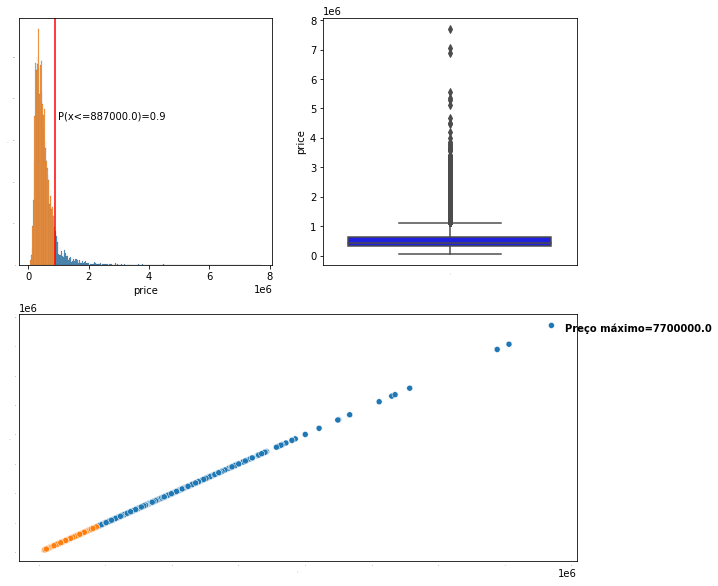

In [63]:
#fazendo uma copia com apenas a coluna que interessa
df_aux=df['price'].copy()
df_aux=pd.DataFrame(df_aux)

#fator de probabilidade
probi=0.9

#funções auxiliares
aux, acu, maxi=acumulativo(df_aux, probi)
df_aux.insert(1,'bool',prob(df_aux, aux))


fig=plt.figure(figsize=(10,10))


#histograma
ax=fig.add_subplot(2,2,1)
sns.histplot(data=df_aux[["price","bool"]],x="price",hue="bool",multiple="stack", legend=False)
plt.ylabel([], fontsize=0)
plt.ylabel([], fontsize=0)
plt.tick_params(axis='y', labelsize=0, length=0)
plt.axvline(x=maxi, ymin=0, ymax=700, color='red')
plt.text(maxi+100000, 700, f"""P(x<={maxi})={probi}""")


#boxplot
ax=fig.add_subplot(2,2,2)
sns.boxplot(y="price",data=df,color='blue')
plt.xlabel([], fontsize=0)
plt.tick_params(axis='x', labelsize=0, length=0)


#dipersão
ax=fig.add_subplot(2,1,2)
sns.scatterplot(data=df_aux, x='price', y='price', hue='bool', legend=False)
plt.ylabel('price')
plt.tick_params(axis='x', labelsize=0, length=0)
maximo=df['price'].max()
plt.text(maximo+200000, maximo-200000, f"Preço máximo={maximo}", weight="bold")
plt.xlabel([], fontsize=0)
plt.ylabel([], fontsize=0)
plt.tick_params(axis='y', labelsize=0, length=0)
plt.show()

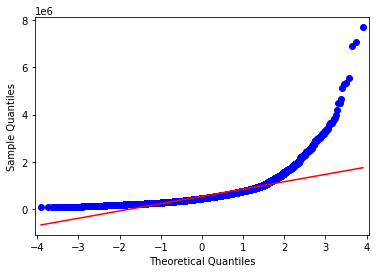

In [64]:
smi.qqplot(df["price"], line = "r")
plt.show()

In [65]:
stat_test, p_valor =stats.normaltest(df["price"])
alpha=0.05
if p_valor < alpha:  # hipotese nula: x vem de uma distribuição normal
    print("A hipotese nula pode ser rejeitada")
else:
    print("A hipotese nula não pode ser rejeitada")

A hipotese nula pode ser rejeitada


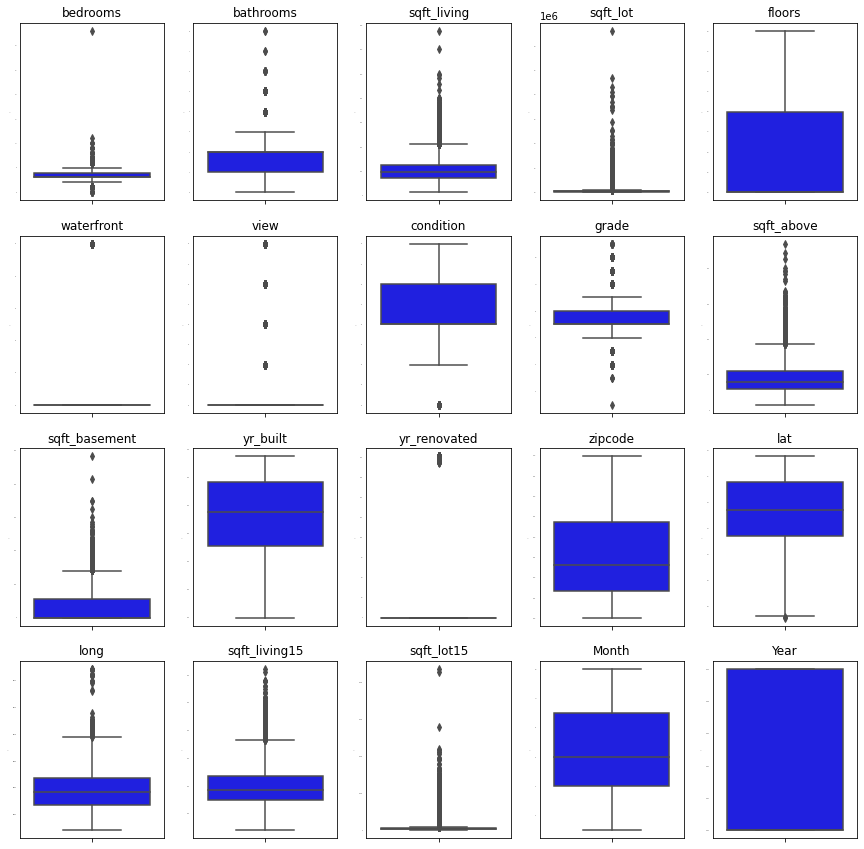

In [66]:
fig=plt.figure(figsize=(15,15))


k = 1

for i in df.columns[3:]:

    ax = fig.add_subplot(4,5,k)
    ax.set_title(f'{i}')
    
    sns.boxplot(y=f"{i}",data=df,color='blue')
    plt.ylabel([], fontsize=0)
    plt.ylabel([], fontsize=0)
    plt.tick_params(axis='y', labelsize=0, length=0)
    k+=1

plt.show()

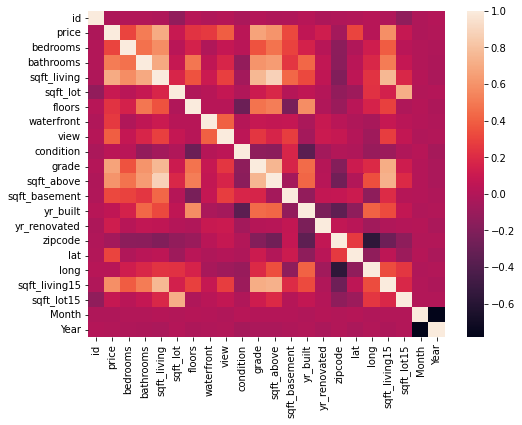

In [67]:

corr_df = df.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=False)
plt.show()

Text(0.5, 0, 'sqft_living')

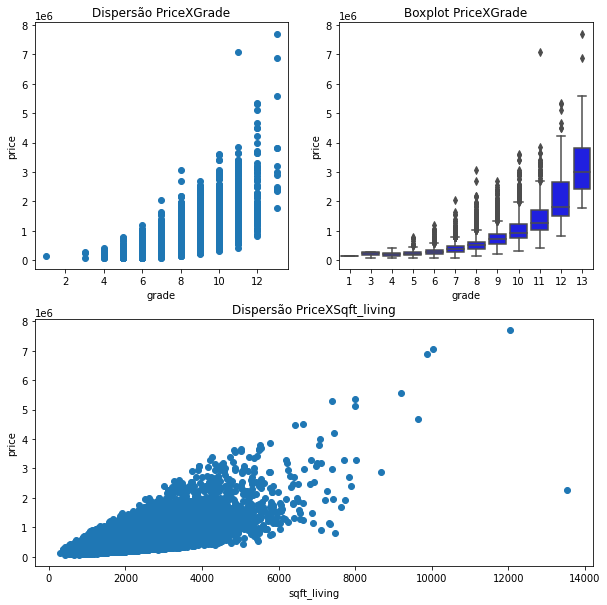

In [68]:
fig=plt.figure(figsize=(10,10))

ax=fig.add_subplot(2,2,1)
ax.set_title('Dispersão PriceXGrade')
plt.scatter(df.grade,df.price)
plt.ylabel('price')
plt.xlabel('grade')


ax=fig.add_subplot(2,2,2)
ax.set_title('Boxplot PriceXGrade')
sns.boxplot(x="grade",y="price",data=df,color='blue')






ax=fig.add_subplot(2,1,2)
ax.set_title('Dispersão PriceXSqft_living')
plt.scatter(df.sqft_living,df.price)
plt.ylabel('price')
plt.xlabel('sqft_living')






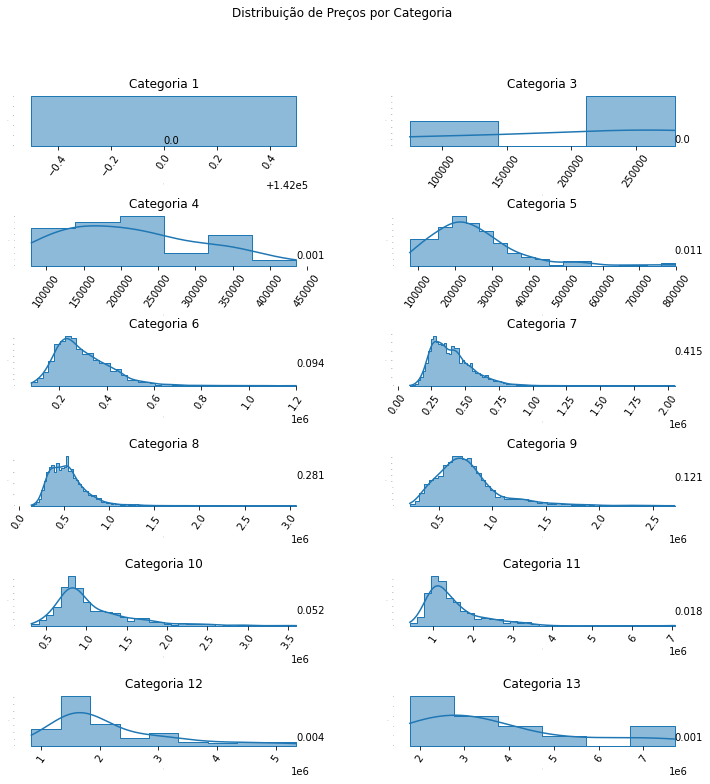

In [69]:
fig=plt.figure(figsize=(12,12))

plt.subplots_adjust(wspace=0.3, hspace=1.3)

#pega a frequencia
cont=df['grade'].value_counts(normalize=True)


#pegar o preço mais alto de cada grade
grop=df[['grade','price']].groupby('grade').max()

#pegar a frequencia de cada preço por grade
grop2=df[['grade','price']].groupby(['grade', 'price']).size()

#colocando em ordem o vetor de valores unicos de grade
value=pd.DataFrame(df['grade'].unique()).sort_values(by=0, ascending=True).values
value=np.array(value).reshape(-1)

j=0
for i in value:
    j += 1
    ax = fig.add_subplot(6,2,j)
    sns.histplot(df[df.grade==i].price, kde=True, element='step')
    sns.despine(bottom=True, left=True)
    ax.set_title(f"Categoria {i}")

    for tick in ax.get_xticklabels():
            tick.set_rotation(55)
            
    plt.tick_params(axis='y', labelsize=0, length=0)
    plt.ylabel([], fontsize=0)
    plt.xlabel([], fontsize=0)
    probabi = cont[i]
    plt.text(grop.loc[i], (grop2.loc[i].sum())/25, f"""{round(probabi, 3)}""")
    fig.suptitle('Distribuição de Preços por Categoria')

    
plt.show()

#teste
#x=df[['grade','price']].groupby(['grade', 'price']).size()
#filtro=df.isin({'price':[250000], 'grade':[7]})
#print(df[(filtro.price) & (filtro.grade)].shape)
    

# **Rede Neural**

Conseguimos perceber melhor que dado a grade, os dados de price parecem seguir uma distribuição poisson


## Tratamento dos outliers

O método para identificar os outliers foi o do boxplot, pois não depende da distribuição da variavel. e os outliers estão sendo tratados por categoria

In [76]:
order = np.array(pd.DataFrame(df['grade'].unique()).sort_values(by=0, ascending=True)).reshape(-1)

auxiliar = df.copy()



for gd in order:
    
    ax = df.loc[df['grade']==gd,['price','grade']].copy()
    
    q3 = ax['price'].quantile(0.75)
    q1 = ax['price'].quantile(0.25)
    
    iqr = q3-q1
    lif = q1-(iqr*1.5)
    lsp = q3+(iqr*1.5)
    
    ax.loc[(ax['price']<lif) | (ax['price']>lsp),'price']=np.nan
    
    
    imputer = KNNImputer(n_neighbors=15, weights='uniform', metric='nan_euclidean')
    imputer.fit(ax)




    auxiliar.loc[df['grade']==gd,['price','grade']] = imputer.transform(ax)
    

ax2 = df.copy()
ax2['price'] = auxiliar['price']

print('Quantidade de outliers antes e depois')
    
total1=0
total2=0
for gd in order:
    ax0=df.loc[df['grade']==gd].copy()
    ax=ax2.loc[ax2['grade']==gd].copy()
    
    
    q33 = df['price'].quantile(0.75)
    q11 = df['price'].quantile(0.25)
    
    iqr1 = q33-q11
    lif1 = q11-(iqr1*1.5)
    lsp1 = q33+(iqr1*1.5)
    
    q3 = ax['price'].quantile(0.75)
    q1 = ax['price'].quantile(0.25)
    
    iqr = q3-q1
    lif = q1-(iqr*1.5)
    lsp = q3+(iqr*1.5)
    
    ax.loc[(ax['price']<lif) | (ax['price']>lsp)]=np.nan
    val1=ax['price'].isnull().sum()
    
    ax0.loc[(df['price']<lif1) | (df['price']>lsp1)]=np.nan
    val0=ax0['price'].isnull().sum()
    
    total1+=val0
    total2+=val1
    
    
    print(f"categoria {int(gd)} => {val0} | {val1}")
    
    
print(f'Total =======> {total1} | {total2} ')
    

Quantidade de outliers antes e depois
categoria 1 => 0 | 0
categoria 3 => 0 | 0
categoria 4 => 0 | 0
categoria 5 => 0 | 2
categoria 6 => 1 | 18
categoria 7 => 12 | 53
categoria 8 => 120 | 55
categoria 9 => 289 | 69
categoria 10 => 366 | 40
categoria 11 => 260 | 18
categoria 12 => 85 | 5
categoria 13 => 13 | 1
Total =======> 1146 | 261 


 Conseguimos tratar aproximadamente 77% dos outliers, de modo que não são mais outliers no novo conjunto de dados

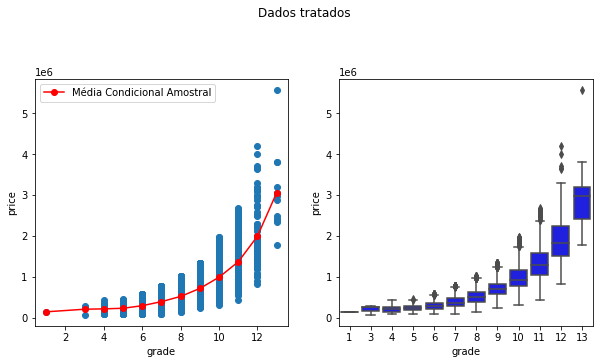

In [77]:
grop=ax2[['grade','price']].groupby('grade').mean()

fig=plt.figure(figsize=(10,10))
fig.suptitle('Dados tratados')



ax=fig.add_subplot(2,2,1)
plt.scatter(ax2.grade,ax2.price)
plt.ylabel('price')
plt.xlabel('grade')


plt.plot(grop.index,grop.price, 'o-', color='red',label='Média Condicional Amostral')
plt.legend()



ax=fig.add_subplot(2,2,2)
sns.boxplot(x="grade",y="price",data=ax2,color='blue')



##**Normalização**


In [78]:

x_scale = StandardScaler()
x = ax2.grade.values
x = x.reshape(len(x),1)
x_transformed = x_scale.fit_transform(x)

y_scale = StandardScaler()
y = ax2.price.values
y = y.reshape(len(y),1)
y_transformed = y_scale.fit_transform(y)


##Desempenho



In [ ]:
resultados_rede_neural = []

for i in range(30):
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)

    rede_neural = rn()
    scores = cross_val_score(rede_neural, x_transformed, y_transformed.ravel(), cv = kfold)
    resultados_rede_neural.append(scores.mean())

In [ ]:
pd.Series(resultados_rede_neural).describe()

count    30.000000
mean      0.613121
std       0.000890
min       0.611175
25%       0.612522
50%       0.612989
75%       0.613677
max       0.614751
dtype: float64

## Rede Neural

In [116]:
rede_neural = rn()
rede_neural.fit(x_transformed,y_transformed.ravel())
R=rede_neural.score(x_transformed,y_transformed.ravel())

## Visualização

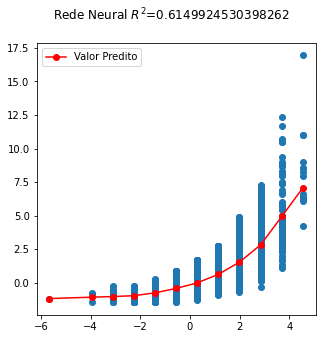

In [117]:
fig=plt.figure(figsize=(5,5))
fig.suptitle(r'Rede Neural $R^{2}$='+f'{R}')


plt.scatter(x_transformed,y_transformed)

x_aux = np.array(sorted(pd.Series(x_transformed.reshape(-1)).unique()))
x_aux = x_aux.reshape(len(x_aux),1)

y_aux = rede_neural.predict(x_aux)
plt.plot(x_aux,y_aux,'o-',color='red',label='Valor Predito')
plt.legend()

#**Regressão** **Linear** 

##Tratamento de Outliers

In [ ]:
detector = KNN(n_neighbors=1)
detector.fit(df.iloc[:,[0,3]])
previsoes = detector.labels_

outliers_index = []
for i in range(len(previsoes)):

  if previsoes[i] == 1:
    outliers_index.append(i)

df_aux = df.copy()
df_aux['bool'] = np.zeros(len(df))
df_aux.loc[outliers_index,'bool']=1
df_aux['bool'].replace({0:'Normal',1:'Outlier'},inplace=True)

Text(0.5, 0, 'sqft_living')

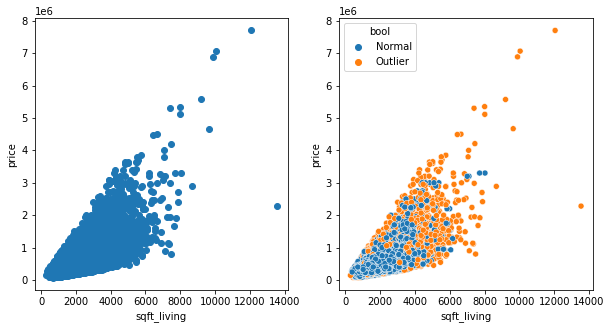

In [ ]:
fig=plt.figure(figsize=(10,5))



ax = fig.add_subplot(1,2,1)
plt.scatter(df.sqft_living,df.price)

plt.ylabel('price')
plt.xlabel('sqft_living')



ax = fig.add_subplot(1,2,2)
sns.scatterplot(data=df_aux,x='sqft_living',y='price',hue='bool')

plt.ylabel('price')
plt.xlabel('sqft_living')

In [ ]:
ax3 = df.copy()
ax3.loc[outliers_index,['price','sqft_living']] = np.nan

In [ ]:
imputer = KNNImputer(n_neighbors=15, weights='uniform', metric='nan_euclidean')
imputer.fit(ax3)


ax3 = pd.DataFrame(imputer.transform(ax3),columns=ax3.columns)
ax3.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,Month,Year
0,221900.0,3.0,1.0,1180.0,5650.0,1.0,0.0,0.0,7.0,1180.0,0.0,1955.0,1340.0,5650.0,10.0,2014.0
1,538000.0,3.0,2.0,2570.0,7242.0,2.0,0.0,0.0,7.0,2170.0,400.0,1951.0,1690.0,7639.0,12.0,2014.0
2,180000.0,2.0,1.0,770.0,10000.0,1.0,0.0,0.0,6.0,770.0,0.0,1933.0,2720.0,8062.0,2.0,2015.0
3,604000.0,4.0,3.0,1960.0,5000.0,1.0,0.0,0.0,7.0,1050.0,910.0,1965.0,1360.0,5000.0,12.0,2014.0
4,510000.0,3.0,2.0,1680.0,8080.0,1.0,0.0,0.0,8.0,1680.0,0.0,1987.0,1800.0,7503.0,2.0,2015.0


Text(0.5, 0, 'sqft_living')

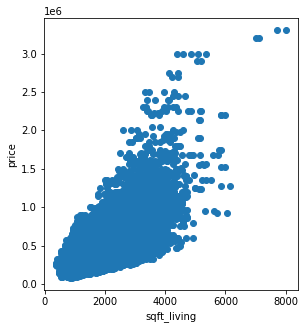

In [ ]:
fig=plt.figure(figsize=(10,5))



ax = fig.add_subplot(1,2,1)
plt.scatter(ax3.sqft_living,ax3.price)

plt.ylabel('price')
plt.xlabel('sqft_living')

##**Normalização**


In [ ]:
x_scale = StandardScaler()
x = ax3.sqft_living.values
x = x.reshape(len(x),1)
x_transformed = x_scale.fit_transform(x)

y_scale = StandardScaler()
y = ax3.price.values
y = y.reshape(len(y),1)
y_transformed = y_scale.fit_transform(y)

foi feita regressão com rede neural para comparação

In [ ]:
rede_neural=rn()
rede_neural.fit(x_transformed,y_transformed.ravel())
R=rede_neural.score(x_transformed,y_transformed.ravel())

regressão linear

In [ ]:
regressao_linear = LinearRegression()
regressao_linear.fit(x_transformed,y_transformed.ravel())
R2=regressao_linear.score(x_transformed,y_transformed.ravel())

## Visualização

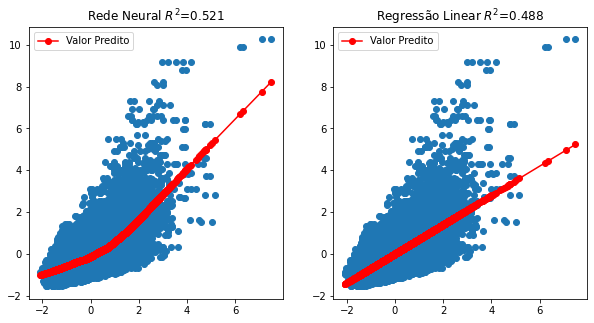

In [ ]:
fig=plt.figure(figsize=(10,5))


ax = fig.add_subplot(1,2,1)
ax.set_title(r'Rede Neural $R^{2}$='+f'{round(R,3)}')

plt.scatter(x_transformed,y_transformed)

x_aux = np.array(sorted(pd.Series(x_transformed.reshape(-1)).unique()))
x_aux = x_aux.reshape(len(x_aux),1)

y_aux = rede_neural.predict(x_aux)
plt.plot(x_aux,y_aux,'o-',color='red',label='Valor Predito')
plt.legend()


ax = fig.add_subplot(1,2,2)
ax.set_title(r'Regressão Linear $R^{2}$='+f'{round(R2,3)}')

plt.scatter(x_transformed,y_transformed)

x_aux = np.array(sorted(pd.Series(x_transformed.reshape(-1)).unique()))
x_aux = x_aux.reshape(len(x_aux),1)

y_aux = regressao_linear.predict(x_aux)
plt.plot(x_aux,y_aux,'o-',color='red',label='Valor Predito')
plt.legend()


# **Usando todos atributos**

In [39]:
detector = KNN(n_neighbors=7)
detector.fit(df.iloc[:,2:])
previsoes = detector.labels_

outliers_index = []
for i in range(len(previsoes)):

  if previsoes[i] == 1:
    outliers_index.append(i)

df_aux = df.loc[:,'price':].copy()

In [40]:
df_aux.loc[outliers_index,:] = np.nan

In [41]:
imputer = KNNImputer(n_neighbors=7, weights='uniform', metric='nan_euclidean')
imputer.fit(df_aux)


df_aux = pd.DataFrame(imputer.transform(df_aux),columns=df_aux.columns)
df_aux.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Month,Year
0,221900.0,3.0,1.0,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,...,0.0,1955.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0,10.0,2014.0
1,538000.0,3.0,2.0,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,...,400.0,1951.0,1991.0,98125.0,47.7210,-122.319,1690.0,7639.0,12.0,2014.0
2,180000.0,2.0,1.0,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,...,0.0,1933.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0,2.0,2015.0
3,604000.0,4.0,3.0,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,...,910.0,1965.0,0.0,98136.0,47.5208,-122.393,1360.0,5000.0,12.0,2014.0
4,510000.0,3.0,2.0,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,...,0.0,1987.0,0.0,98074.0,47.6168,-122.045,1800.0,7503.0,2.0,2015.0


In [118]:
x_scale = StandardScaler()
x = df.loc[:,'bedrooms':'Year'].values
x_transformed = x_scale.fit_transform(x)

y_scale = StandardScaler()
y = df.price.values
y = y.reshape(len(y),1)
y_transformed = y_scale.fit_transform(y)

In [119]:
pca = PCA(0.95)

x_pca = pca.fit_transform(x_transformed)

In [120]:
rede_neural = rn(hidden_layer_sizes=(9,9),max_iter=1000)
rede_neural.fit(x_pca,y_transformed.ravel())
rede_neural.score(x_pca,y_transformed.ravel())

0.8916661577232783

In [ ]:
resultados_rede_neural = []

for i in range(30):
    
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)

    rede_neural = rn()
    scores = cross_val_score(rede_neural, x_transformed, y_transformed.ravel(), cv = kfold)
    resultados_rede_neural.append(scores.mean())

In [122]:
pd.Series(resultados_rede_neural).describe()

count    30.000000
mean      0.880501
std       0.001467
min       0.877684
25%       0.879342
50%       0.880447
75%       0.881715
max       0.883048
dtype: float64